#Libraries and data preprocessing


##Import 

Import libraries and print some versions.

To use GPU, set `Edit / Notebook settings / Hardware accelerator` to **GPU**.

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator

print("Tensorflow version %s" %tf.__version__)
print("Keras version %s" %keras.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.4.0
Keras version 2.4.3
Found GPU at: /device:GPU:0


## Load data

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#%cd /content/drive/MyDrive/Colab\ Notebooks/nodup_classification
%cd /content/drive/MyDrive/

%ls

## Unzip the dataset folder and split in train and test folders

In [ ]:
!unzip /content/drive/MyDrive/train_dataset.zip

%cd /content/drive/MyDrive/train_dataset/

%ls

In [ ]:
import math
from typing import List
import os
import argparse
import glob
import shutil


# Get all files in the current directory
def list_files(path):
    files = os.listdir(path)
    return np.asarray(files)

def split_files(oldpath, newpath, classes):
    for name in classes:
        full_dir = os.path.join(os.getcwd(), f"{oldpath}/{name}")

        files = list_files(full_dir)
        total_file = np.size(files,0)
        # We split data set into 3: train, validation and test
        
        train_size = math.ceil(total_file * 0.8) # 80% for training 

        #validation_size = train_size + math.ceil(total_file * 0.1) # 10% for validation
        #test_size = validation_size + math.ceil(total_file * 0.1) # 10% for testing 
        test_size = train_size + math.ceil(total_file * 0.2) # 20% for testing 
        
        train = files[0:train_size]
        #validation = files[train_size:validation_size]
        #test = files[validation_size:]
        test = files[train_size:]

        move_files(train, full_dir, f"train/{name}")
        #move_files(validation, full_dir, f"validation/{name}")
        move_files(test, full_dir, f"test/{name}")

def move_files(files, old_dir, new_dir):
    new_dir = os.path.join(os.getcwd(), new_dir);
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)

    for file in np.nditer(files):
        old_file_path = os.path.join(os.getcwd(), f"{old_dir}/{file}")
        new_file_path = os.path.join(os.getcwd(), f"{new_dir}/{file}")

        shutil.move(old_file_path, new_file_path)


Specify the classes for the classification

In [ ]:
newpath ='./'
classes = ['glass food container', 'potato crisps', 'sports drinking water',
'pasta sides','replacement heads', 'steak knives', 'plums', 'side dish plate'];

split_files('./', './', classes)

#Delete empty subfolders

import os
#root = os.getcwd() #CHANGE THIS TO PATH IF REQUIRED
root = '/content/drive/MyDrive/train_dataset'
folders = sorted(list(os.walk(root))[1:],reverse=True)
for folder in folders:
    try:
        os.rmdir(folder[0])
    except OSError as error: 
        print("Directory '{}' can not be removed".format(folder[0])) 

##Data augmentation

In [ ]:
import os

#datadir = '/content/drive/MyDrive/Colab\ Notebooks/NN_Dataset'
#trainingset = datadir+'/train/'
trainingset = '/content/drive/MyDrive/train_dataset/train/'
#testset = datadir + '/validation/'
testset = '/content/drive/MyDrive/train_dataset/test/'

batch_size = 32
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False)

train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(224, 224), # requirements: AlexNet (227,227), others (224,224)
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(224, 224), # requirements: AlexNet (227,227), others (224,224)
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))


Found 7026 images belonging to 8 classes.
Found 1753 images belonging to 8 classes.
Image input (224, 224, 3)
Classes: ['glass food container', 'pasta sides', 'plums', 'potato crisps', 'replacement heads', 'side dish plate', 'sports drinking water', 'steak knives']
Loaded 7026 training samples from 8 classes.
Loaded 1753 test samples from 8 classes.


###Show *n* random images


pasta sides


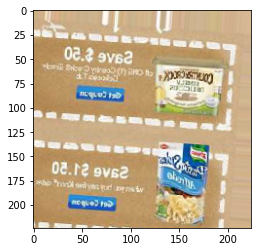

side dish plate


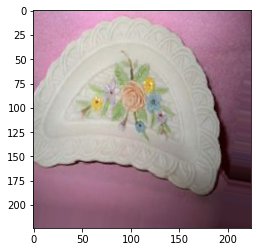

sports drinking water


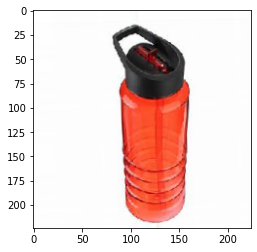

In [ ]:
import matplotlib.pyplot as plt

n = 3
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()
    
    


#Training a network from scratch

##AlexNet

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 109, 55, 96)       34944     
_________________________________________________________________
activation (Activation)      (None, 109, 55, 96)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 27, 96)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 54, 27, 96)        384       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 17, 256)       2973952   
_________________________________________________________________
activation_1 (Activation)    (None, 44, 17, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 8, 256)       

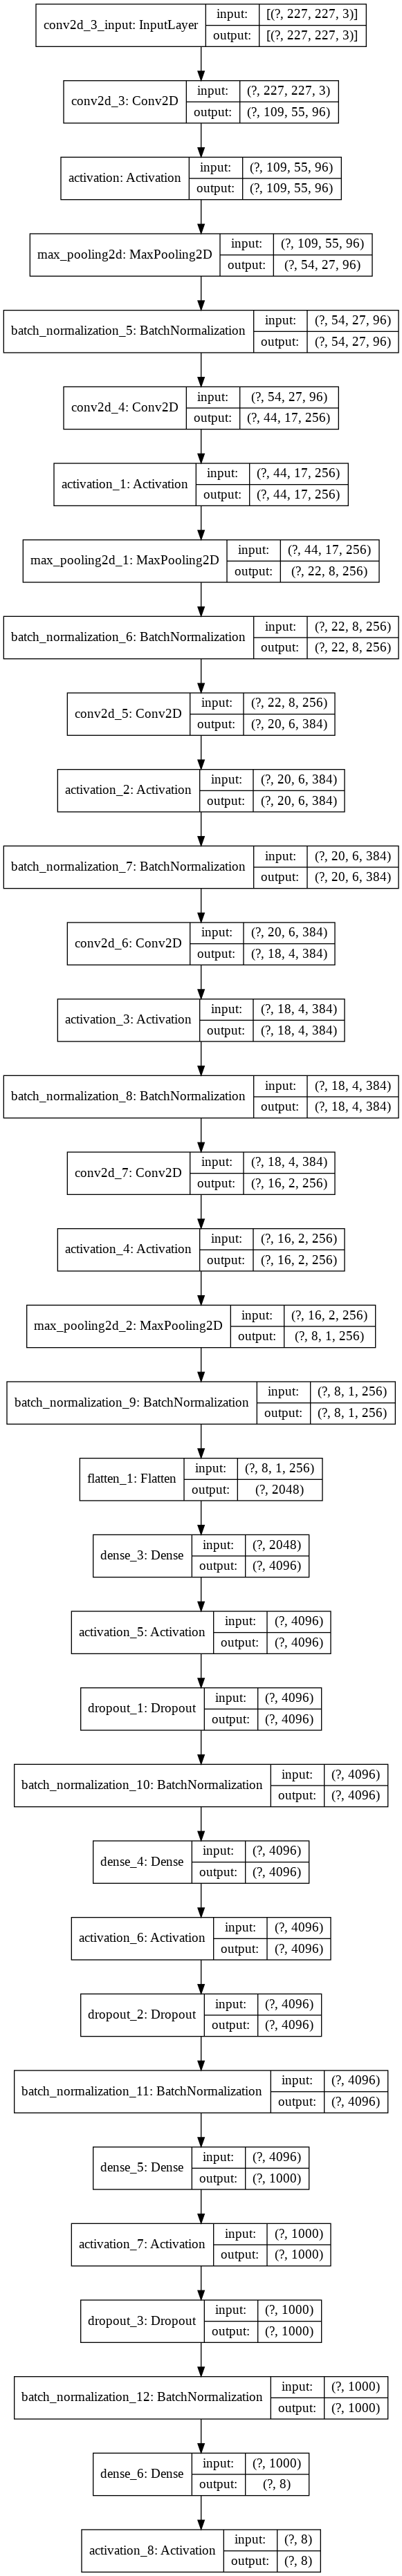

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers
from keras.utils import plot_model

def AlexNet(input_shape, num_classes, regl2 = 0.0001, lr=0.0001):

    model = Sequential()

    # C1 Convolutional Layer 
    model.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(11,11),\
                     strides=(2,4), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # C2 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C3 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C4 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C5 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)
    
    # D1 Dense Layer
    model.add(Dense(4096, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D2 Dense Layer
    model.add(Dense(4096, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D3 Dense Layer
    model.add(Dense(1000,kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile

    adam = optimizers.Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model
 
# create the model
model = AlexNet(input_shape,num_classes)
model.summary()

# plot model architecture
plot_model(model, show_shapes=True, to_file='AlexNet_module.png')


##VGG16

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 227, 227, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 227, 227, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 113, 113, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 113, 113, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 113, 113, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

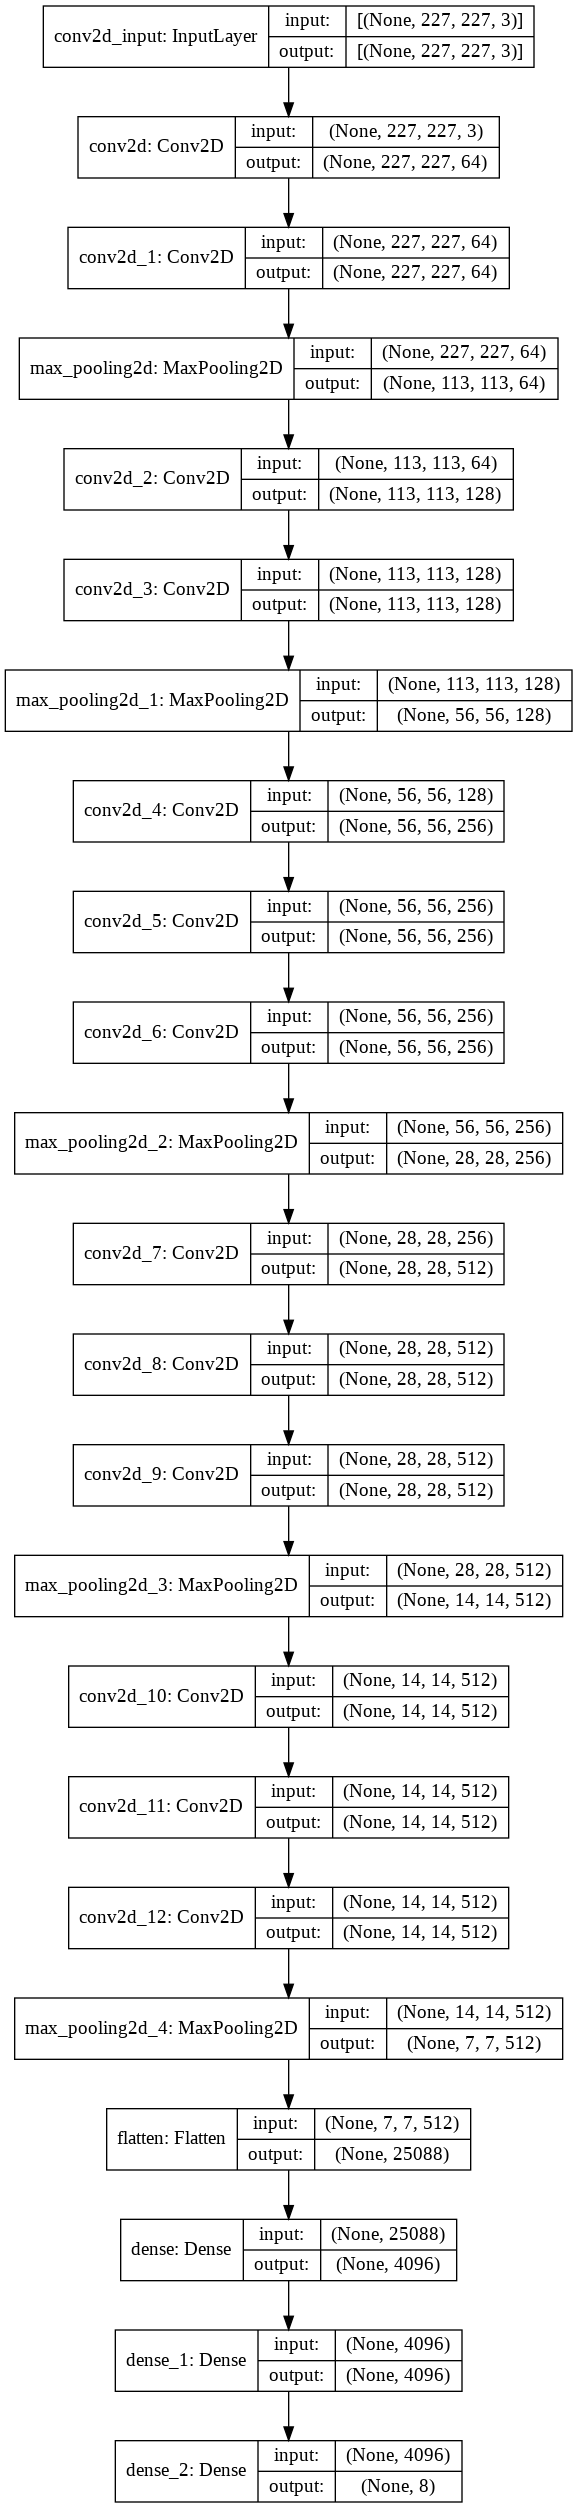

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.optimizers import Adam
from keras.utils import plot_model

def VGG_16(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=num_classes, activation="softmax"))


    from keras.optimizers import Adam
    opt = Adam(lr=0.0001)
    model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

    return model

    # create the model
model = VGG_16(input_shape,num_classes)
model.summary()

# plot model architecture
plot_model(model, show_shapes=True, to_file='vgg16_module.png')

## Net from scratch (Netfs)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 12)      4368      
_________________________________________________________________
average_pooling2d (AveragePo (None, 56, 56, 12)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 12)        48        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        24608     
_________________________________________________________________
average_pooling2d_1 (Average (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 240)         4

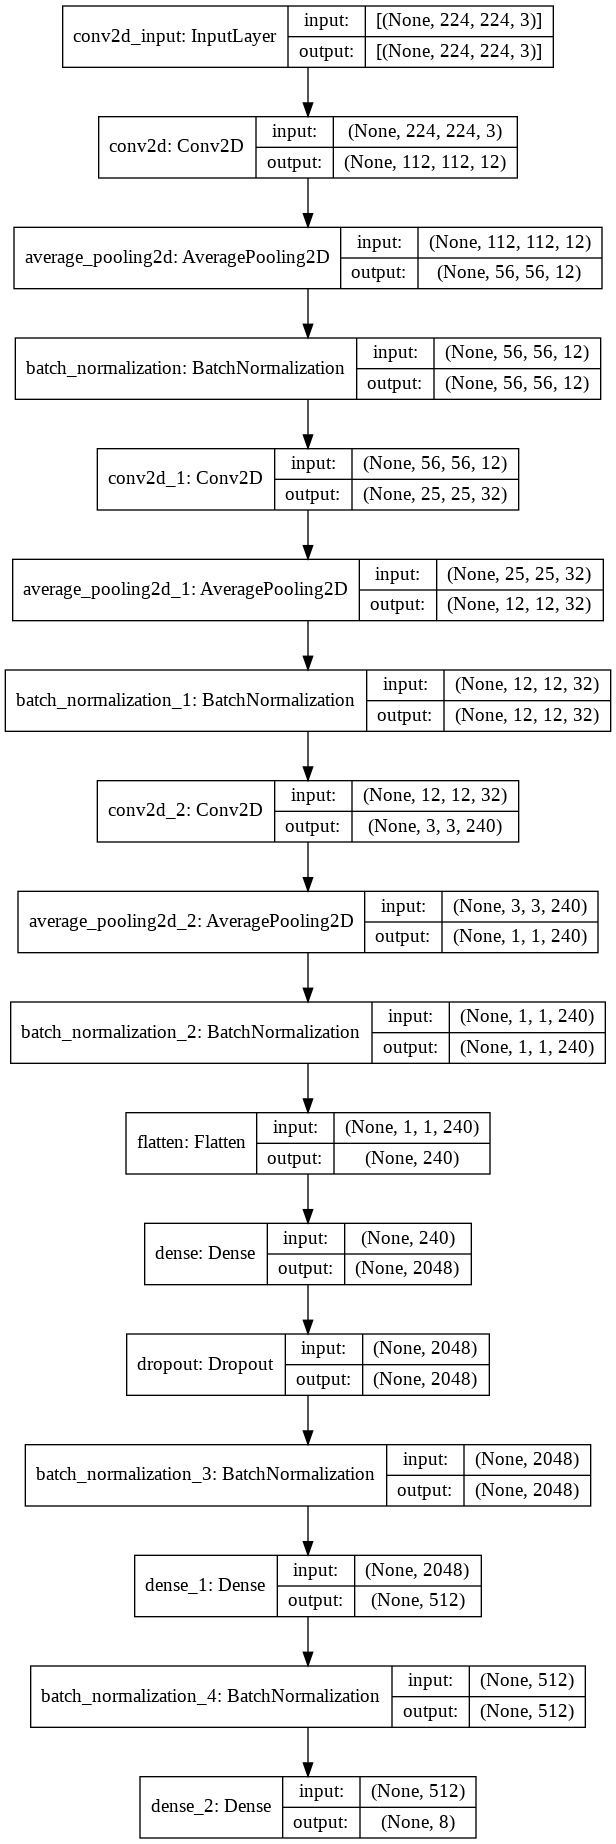

In [ ]:
import keras,os
from keras.models import Sequential
from keras import models, layers, backend
from keras.layers import Dense, Activation, Dropout, Flatten,\
    Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model

def NetfromScratch(input_shape, num_classes):

    model = Sequential()
    
    model.add(Conv2D(12, kernel_size=(11, 11), strides=(2, 2), activation='relu', input_shape=input_shape, padding="same"))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(8, 8), strides=(2, 2), activation='relu', padding='valid'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(240, kernel_size=(8, 8), strides=(2, 2), activation='relu', padding='valid'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(num_classes, activation='softmax'))

    #optimizer = 'SGD' #alternative 'SGD'
    optimizer = "adam"
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    
    return model

    # create the model
model = NetfromScratch(input_shape,num_classes)
model.summary()

# plot model architecture
plot_model(model, show_shapes=True, to_file='netfromscratch_module.png')

#Transfer Learning

## Load base VGG16 model

Load VGG16 model pre-trained with ImageNet

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________________________

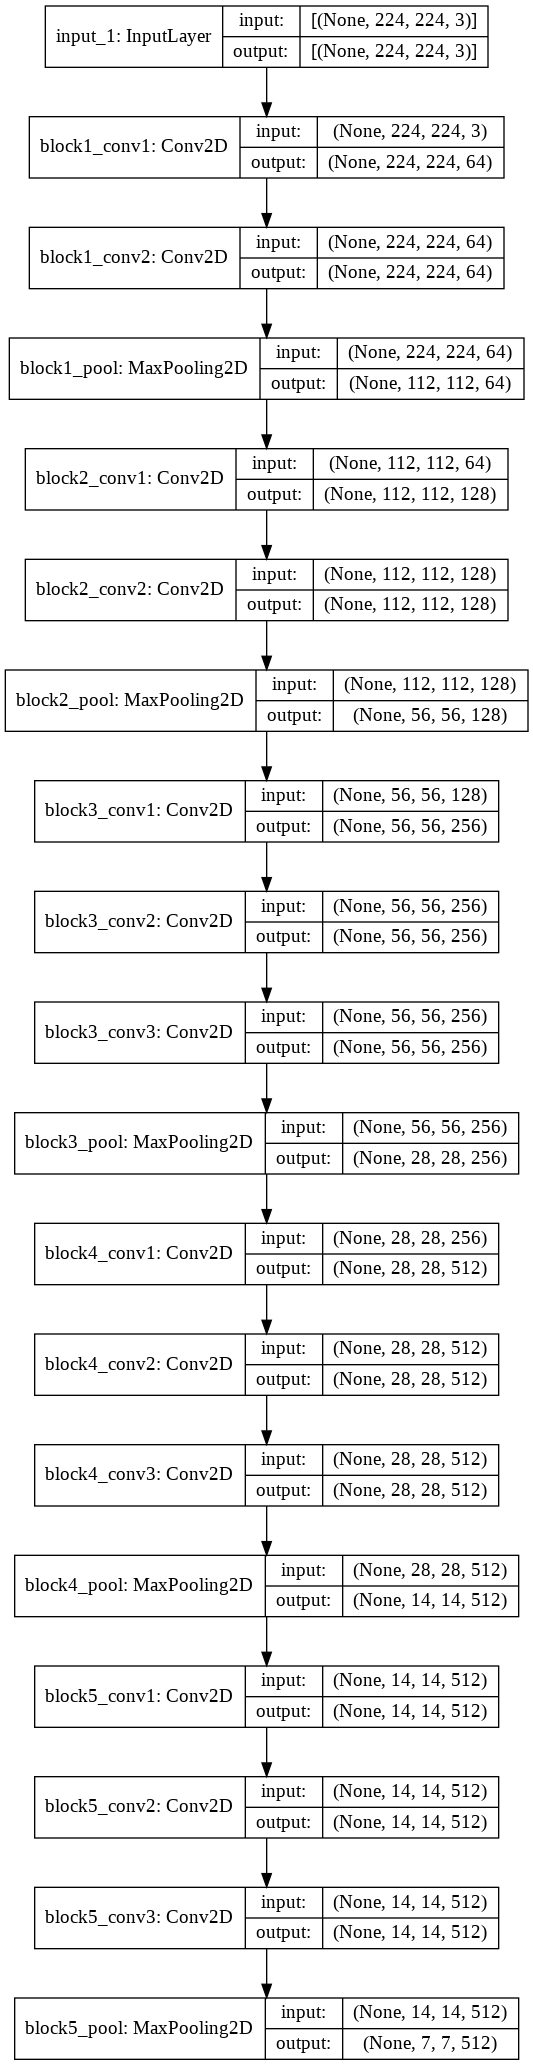

In [ ]:
import keras,os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,\
                         UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras import optimizers
from keras import callbacks
from keras.utils import plot_model

# Load VGG16 model 
# init_weights='imagenet' if you want to use the pretrained model
def load_vgg16_features(input_shape, init_weights='imagenet'):
    
    # define input tensor
    input0 = Input(shape=input_shape)

    # load VGG16 model (possibly pretrained model on imagenet) without the final dense layers (include_top=False)
    vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights=init_weights, input_tensor=input0)
    
    feature_extractor = keras.models.Model(inputs=input0, outputs=vgg16_model.output, name="vgg16_features")

    optimizer = 'adam' #alternative 'sgd'

    feature_extractor.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return feature_extractor

vgg16feat_model = load_vgg16_features(input_shape)
vgg16feat_model.summary()

# plot model architecture
plot_model(vgg16feat_model, show_shapes=True, to_file='vgg16feat.png')

##VGG16-TransferNet

Transfer learning from VGG16 trained on ImageNet

In [ ]:
def transferNet(input_shape, num_classes, output_layer_name, trainable_layers):
    
    # load the pre-trained model
    feature_extractor = load_vgg16_features(input_shape, init_weights='imagenet')

    # get the original input layer tensor
    input_t = feature_extractor.get_layer(index=0).input

    # set the feture extractor layers as non-trainable
    for idx,layer in enumerate(feature_extractor.layers):
      if layer.name in trainable_layers:
        layer.trainable = True
      else:
        layer.trainable = False

    # get the output tensor from a layer of the feature extractor
    output_extractor = feature_extractor.get_layer(name = output_layer_name).output
    
    #output_extractor = MaxPooling2D(pool_size=(4,4))(output_extractor)

    # flat the output of a Conv layer
    flatten = Flatten()(output_extractor) 
    flatten_norm = BatchNormalization()(flatten)

    # add a Dense layer
    dense1 = Dropout(0.4)(flatten_norm)
    dense1 = Dense(200, activation='relu')(dense1)
    dense1 = BatchNormalization()(dense1)
    
    # add a Dense layer
    dense2 = Dropout(0.4)(dense1)
    dense2 = Dense(100, activation='relu')(dense2)
    dense2 = BatchNormalization()(dense2)

    # add the final output layer
    dense3 = BatchNormalization()(dense2)
    dense3 = Dense(num_classes, activation='softmax')(dense3)
    
    model = keras.models.Model(inputs=input_t, outputs=dense3, name="transferNet")
    
    optimizer = 'adam' #alternative 'SGD'
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return model



# choose the layer from which you can get the features (block5_pool the end, glob_pooling to get the pooled version of the output)
name_output_extractor = "block5_pool"
trainable_layers = ["block5_conv3"]

# build the transfer model
transfer_model = transferNet(input_shape, num_classes, name_output_extractor, trainable_layers)
transfer_model.summary()

Model: "transferNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       

#Train and Evaluation

## Train

Note: first epoch takes much longer for initialization and caching.

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1
epochs = 100

csv_logger = CSVLogger('/content/drive/MyDrive/train_dataset/history/vgg16_TransferNet.csv')
checkpoint = ModelCheckpoint("vgg16_TransferNet.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, verbose=1, mode='auto')

try:
    history = transfer_model.fit(train_generator, epochs=epochs, verbose=1,\
    #history = model.fit(train_generator, epochs=epochs, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps,\
                    callbacks=[checkpoint,early,csv_logger])
except KeyboardInterrupt:
    pass


Epoch 1/100
219/219 [==============================] - 3201s 15s/step - loss: 1.2272 - accuracy: 0.5807 - val_loss: 1.0041 - val_accuracy: 0.6908

Epoch 00001: val_accuracy improved from -inf to 0.69082, saving model to vgg16_TransferNet.h5
Epoch 2/100
219/219 [==============================] - 99s 450ms/step - loss: 0.6664 - accuracy: 0.7749 - val_loss: 0.8832 - val_accuracy: 0.7171

Epoch 00002: val_accuracy improved from 0.69082 to 0.71706, saving model to vgg16_TransferNet.h5
Epoch 3/100
219/219 [==============================] - 99s 453ms/step - loss: 0.5656 - accuracy: 0.8028 - val_loss: 0.8489 - val_accuracy: 0.7404

Epoch 00003: val_accuracy improved from 0.71706 to 0.74044, saving model to vgg16_TransferNet.h5
Epoch 4/100
219/219 [==============================] - 100s 455ms/step - loss: 0.4911 - accuracy: 0.8301 - val_loss: 0.8610 - val_accuracy: 0.7536

Epoch 00004: val_accuracy improved from 0.74044 to 0.75357, saving model to vgg16_TransferNet.h5
Epoch 5/100
219/219 [=====

##Plot training results

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("metrics")
plt.xlabel("epoch")
plt.legend(["accuracy","validation accuracy","loss","validation loss"])
plt.show()
plt.savefig('netfs.eps', bbox_inches='tight')

NameError: ignored

##Save the model

In [ ]:
import os

models_dir = '/content/drive/MyDrive/train_dataset/models'

def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)

# Save the model
savemodel(model,'8classes_alexnet2_100_epochs')


Model saved successfully on file /content/drive/MyDrive/train_dataset/models/8classes_alexnet2_100_epochs.h5



##Load a trained model

In [ ]:
import os
from keras.models import load_model

models_dir = '/content/drive/MyDrive/train_dataset/models'

def loadmodel(problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    try:
        model = load_model(filename)
        print("\nModel loaded successfully from file %s\n" %filename)
    except OSError:    
        print("\nModel file %s not found!!!\n" %filename)
        model = None
    return model

model = loadmodel('vgg16_TransferNet')


Model loaded successfully from file /content/drive/MyDrive/train_dataset/models/vgg16_TransferNet.h5



##Load an history

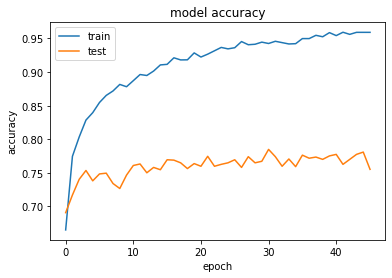

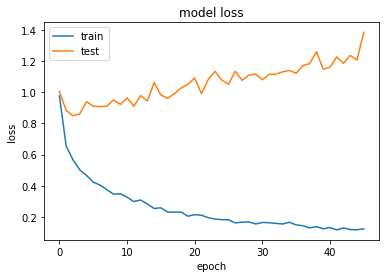

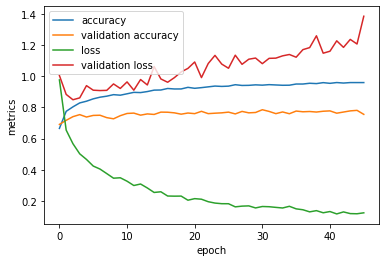

<Figure size 432x288 with 0 Axes>

In [ ]:
import os
import pandas as pd
directory = '/content/drive/MyDrive/train_dataset'
models_dir = directory + '/history/'

history = pd.read_csv(os.path.join(models_dir, 'vgg16_TransferNet.csv'), header=0, index_col=False)

#ens_dim = len(history.keys())//4
#print("This ensemble is composed by %d networks" %ens_dim)

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

import matplotlib.pyplot as plt
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.ylabel("metrics")
plt.xlabel("epoch")
plt.legend(["accuracy","validation accuracy","loss","validation loss"])
plt.show()
plt.savefig('netfs.eps', bbox_inches='tight')

##Evaluate the model

Accuracy on test set

In [ ]:
test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(224, 224), # requirements: AlexNet (227,227), others (224,224)
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)
val_steps=test_generator.n//test_generator.batch_size+1
loss, acc = model.evaluate(test_generator,verbose=1,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)



Found 1753 images belonging to 8 classes.
55/55 [==============================] - 8s 131ms/step - loss: 1.0804 - accuracy: 0.7849
Test loss: 1.080415
Test accuracy: 0.784940


Precision, recall, F-score

In [ ]:

import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(224, 224), # requirements: AlexNet (227,227), others (224,224)
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))


  

Found 1753 images belonging to 8 classes.
55/55 [==============================] - 7s 131ms/step
                       precision    recall  f1-score   support

 glass food container      0.764     0.779     0.772       195
          pasta sides      0.849     0.648     0.735       199
                plums      0.856     0.847     0.851       203
        potato crisps      0.745     0.752     0.749       210
    replacement heads      0.768     0.883     0.822       240
      side dish plate      0.613     0.797     0.693       256
sports drinking water      0.885     0.714     0.790       227
         steak knives      0.949     0.839     0.890       223

             accuracy                          0.785      1753
            macro avg      0.804     0.782     0.788      1753
         weighted avg      0.800     0.785     0.787      1753



Confusion matrix analysis

In [ ]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))
  

Found 1753 images belonging to 8 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


55/55 [==============================] - 6s 112ms/step
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
pasta sides      ->  side dish plate   	28 	1.60 % 
sports drinking water ->  replacement heads  	23 	1.31 % 
glass food container ->  side dish plate   	23 	1.31 % 
potato crisps    ->  side dish plate   	20 	1.14 % 
pasta sides      ->  potato crisps     	20 	1.14 % 
sports drinking water ->  glass food container  	17 	0.97 % 
steak knives     ->  side dish plate   	17 	0.97 % 
plums            ->  side dish plate   	15 	0.86 % 
replacement heads ->  side dish plate   	15 	0.86 % 
side dish plate  ->  replacement heads  	14 	0.80 % 
side dish plate  ->  potato crisps     	12 	0.68 % 
sports drinking water ->  side dish plate   	11 	0.63 % 
potato crisps    ->  plums             	11 	0.63 % 
side dish plate  ->  glass food container  	11 	0.63 % 
potato crisps    ->  pasta sides       	10 	0.57 % 
glass food co